# **Setup Pustaka**

In [14]:
# !pip install --upgrade --force-reinstall numpy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# **Load Dataset**

In [15]:
file_path = "GSE4115_data_set.csv"
df = pd.read_csv(file_path)

print("Shape awal dataset:", df.shape)
print("Kolom awal:", list(df.columns[:8]))


if 'Type' not in df.columns:
    print("\nKolom 'Type' tidak ditemukan — berarti datanya masih probes x samples.")
    df = df.set_index(df.columns[0]).T.reset_index().rename(columns={'index': 'Sample_ID'})
    print("✅ Data ditranspose! Kolom baru:", list(df.columns[:8]))
else:
    print("\n✅ Kolom 'Type' sudah ada — data sudah dalam format sampel x fitur.")

Shape awal dataset: (192, 22217)
Kolom awal: ['Unnamed: 0', '1007_s_at', '1053_at', '117_at', '121_at', '1255_g_at', '1294_at', '1316_at']

✅ Kolom 'Type' sudah ada — data sudah dalam format sampel x fitur.


# **Cek Struktur Data**

In [16]:
if 'Type' not in df.columns:
    print("\nKolom 'Type' tidak ditemukan — berarti datanya masih probes x samples.")
    df = df.set_index(df.columns[0]).T.reset_index().rename(columns={'index': 'Sample_ID'})
    print("✅ Data ditranspose! Kolom baru:", list(df.columns[:8]))
else:
    print("\n✅ Kolom 'Type' sudah ada — data sudah dalam format sampel x fitur.")


✅ Kolom 'Type' sudah ada — data sudah dalam format sampel x fitur.


# **Label Encoding**

In [17]:
def map_label(s):
    s = str(s).lower()
    if 'not diagnosed' in s:
        return 0
    if 'diagnosed' in s:
        return 1
    if 'suspect' in s:
        return np.nan
    return np.nan

df['y_raw'] = df['Type'].apply(map_label)
print("\nDistribusi label awal:\n", df['y_raw'].value_counts(dropna=False))


Distribusi label awal:
 y_raw
1.0    97
0.0    90
NaN     5
Name: count, dtype: int64


# **Drop Suspected**

In [18]:
df = df[~df['y_raw'].isna()].copy()
y = df['y_raw'].astype(int)

# **Pilih Fitur Numerik**

In [19]:
meta_cols = ['Sample_ID', 'Type', 'y_raw']
if 'Unnamed: 0' in df.columns:
    meta_cols.append('Unnamed: 0')

num_cols = [c for c in df.columns if c not in meta_cols]
X_raw = df[num_cols].apply(pd.to_numeric, errors='coerce')
X_raw = X_raw.fillna(X_raw.median())

print("\nJumlah fitur numerik awal:", X_raw.shape[1])


Jumlah fitur numerik awal: 22215


# **Split Data**

In [20]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.3, stratify=y, random_state=42
)
print("\nTrain/Test shapes sebelum threshold:", X_train_raw.shape, X_test_raw.shape)


Train/Test shapes sebelum threshold: (130, 22215) (57, 22215)


# **Variance Threshold**

In [21]:
vt = VarianceThreshold(threshold=0.025)
X_train_vt = vt.fit_transform(X_train_raw)
X_test_vt = vt.transform(X_test_raw)
selected_features = X_train_raw.columns[vt.get_support()]

print("\nFitur awal:", X_train_raw.shape[1])
print("Fitur setelah Variance Threshold:", X_train_vt.shape[1])
print("Jumlah fitur dibuang:", X_train_raw.shape[1] - X_train_vt.shape[1])


Fitur awal: 22215
Fitur setelah Variance Threshold: 1109
Jumlah fitur dibuang: 21106


# **Scaling**

In [22]:
scaler = StandardScaler()
X_train_df_vt = pd.DataFrame(X_train_vt, columns=selected_features, index=X_train_raw.index)
X_test_df_vt = pd.DataFrame(X_test_vt, columns=selected_features, index=X_test_raw.index)

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_df_vt),
    columns=selected_features,
    index=X_train_raw.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_df_vt),
    columns=selected_features,
    index=X_test_raw.index
)

print("\nDistribusi label setelah filtering:\n", y.value_counts())
print("\nTrain/Test shapes setelah threshold & scaling:", X_train_scaled.shape, X_test_scaled.shape)


Distribusi label setelah filtering:
 y_raw
1    97
0    90
Name: count, dtype: int64

Train/Test shapes setelah threshold & scaling: (130, 1109) (57, 1109)


# **Simpan Output**

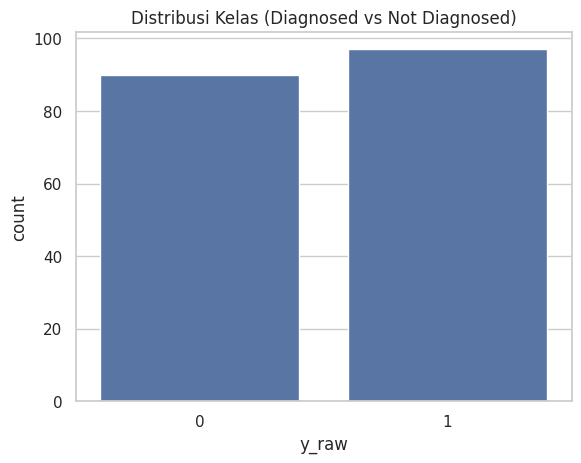

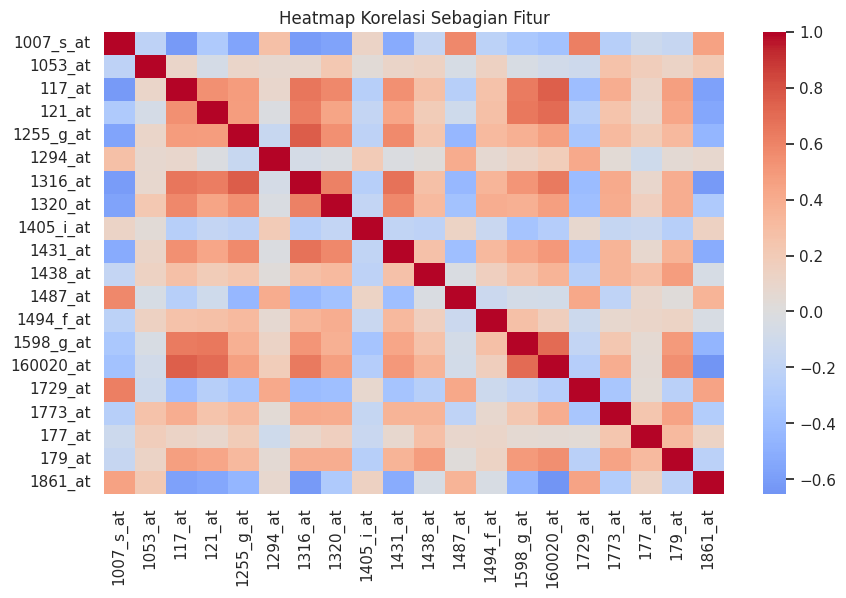

In [23]:
sns.countplot(x=y)
plt.title("Distribusi Kelas (Diagnosed vs Not Diagnosed)")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(X_raw.iloc[:, :20].corr(), cmap='coolwarm', center=0)
plt.title("Heatmap Korelasi Sebagian Fitur")
plt.show()

In [24]:
train_data = pd.concat([X_train_scaled, y_train], axis=1)
test_data = pd.concat([X_test_scaled, y_test], axis=1)

train_data.to_csv("train.csv", index=False)
test_data.to_csv("test.csv", index=False)

print("\n✅ train.csv dan test.csv berhasil disimpan!")
print("Shape train:", train_data.shape, " | Shape test:", test_data.shape)


✅ train.csv dan test.csv berhasil disimpan!
Shape train: (130, 1110)  | Shape test: (57, 1110)
